# **Topic Modeling with NMF and SVD**

## **Getting started**

We'll take a dataset (which contains 18000 newsgroups posts with 20 topics) with several documents and find topic. For this, we'll use SVD and  NMF.

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [0]:
np.set_printoptions(suppress=True)

## **Looking at the data**

Scikit Learn comes with a number of built-in datasets, as well as loading utilities to load several standard external datasets.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape
newsgroups_train.target.shape

(2034,)

We can look at some of the data.

In [5]:
print("\n".join(newsgroups_train.data[3:4]))

I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers them or explictly announces that he
refuses to do so.

--or--

2. If you must respond to one of his articles, include within it
something simila

This way we can have an idea about the topics we might find later. We can check if any of the previous efined topics are in the extract we choose. 

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[3:4]]

array(['alt.atheism'], dtype='<U18')

## **Stop words, stemming and lemmatization**

### **Stop words**

These are extremely common words whith amost no meaning or use for our purpose.

We can check some of these ones using **NTLK**.

In [7]:
from sklearn.feature_extraction import stop_words

sorted(list(stop_words.ENGLISH_STOP_WORDS))[75:90]

['eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except']

### **Stemming and Lemmatization**

Both techniques generate the root form of the words. Lemmatization uses the rules about a language and Stemming just chops the end of the words.

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk import stem

In [0]:
word_list = ['organize', 'organizes', 'organizing']

In [0]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [12]:
[wnl.lemmatize(word) for word in word_list]

['organize', 'organizes', 'organizing']

In [13]:
[porter.stem(word) for word in word_list]

['organ', 'organ', 'organ']

### **Spacy**

Spacy is a modern and fast nlp library. 

In [14]:
!pip install spacy

In [15]:
!spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
import spacy
from spacy.lemmatizer import Lemmatizer

In [0]:
lemmatizer = Lemmatizer()

In [18]:
[lemmatizer.lookup(word) for word in word_list]

['organize', 'organizes', 'organizing']

**Spacy** doesn't offer a stemmer.

As we know, there's no standard deffinition of stop words. We can see that the ones defined in spacy are different from the ones in sklearn.

In [19]:
nlp = spacy.load("en_core_web_sm")
sorted(list(nlp.Defaults.stop_words))[:20]

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also']

It's important to bear in mind all of these variables, cause they can hurt our performance when using deep learning techniques if we don't use them properly.

## **Data processing**

**Scikit learn** has a method that extracts all te word counts.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

In [21]:
vectorizer = CountVectorizer(stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data).todense() 
vectors.shape # returns number of documents and words

(2034, 26576)

In [22]:
vocab = np.array(vectorizer.get_feature_names())
vocab[3000:3020]

array(['alexei', 'alexia', 'alexis', 'alfonso', 'alford', 'alfred', 'alg',
       'algebraic', 'algebraically', 'algeria', 'algiers', 'algiorithm',
       'algirithm', 'algo', 'algo_count', 'algonquin', 'algorhtyms',
       'algorithm', 'algorithmic', 'algorithmically'], dtype='<U80')

## **Singular Value Decomposition**

With sVD we can get topics of ur documents, despite the fact that it's an unsupervised algorithm.

In [0]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [24]:
time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 21s, sys: 4.6 s, total: 1min 25s
Wall time: 44.1 s


In [25]:
show_topics(Vh[:5])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

## **Non-negative Matrix Factorization (NMF)**

We'll use NMF from sklearn.

In [0]:
m, n = vectors.shape
topics = 7 

In [0]:
clf = decomposition.NMF(n_components=topics, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [28]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray send ftp',
 'launch space satellite commercial market satellites year data',
 'jesus matthew prophecy people said messiah david isaiah',
 'image data available software processing ftp edu analysis',
 'god atheists atheism religious believe people religion does',
 'space nasa lunar mars earth shuttle mission probe']

## **Topic Frequency-Inverse Document Frequency **

TF-IDF is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [30]:
newsgroups_train.data[10:12]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [31]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

show_topics(H1)

['don people think just like know say religion',
 'thanks files file image program windows format know',
 'space nasa launch shuttle orbit lunar moon earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe atheism christian belief does',
 'objective morality values moral subjective science absolute claim',
 'graphics comp software group 3d aspects amiga just']

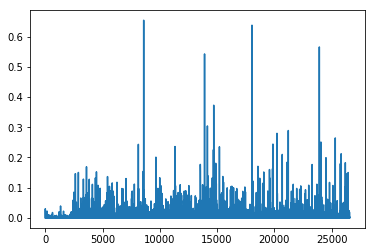

In [32]:
plt.plot(clf.components_[0])